# **Proyek Klasifikasi Gambar: Shoe vs Sandal vs Boot Image Dataset (15K Images)**
- **Nama:** Diana Mulhimah
- **Email:** mulhimahdiana@gmail.com
- **ID Dicoding:** MC330D5X2476

## # **Import Semua Packages/Library yang Digunakan**

In [ ]:
!pip install split-folders

# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
import os
import splitfolders

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise
from skimage import io, img_as_ubyte
from collections import OrderedDict

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.initializers import he_normal
from google.colab import files

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


## **Data Preparation**

In [ ]:
# Import module yang disediakan google colab untuk kebutuhan upload file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dianamulhimah","key":"5ac01096e5e606f709925aa946111159"}'}

In [ ]:
# Download kaggle dataset and unzip the file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images
!unzip -o "/content/shoe-vs-sandal-vs-boot-dataset-15k-images.zip" -d "/content/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1).jpg  
  inflating: /content/Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (10).jpg  
  inflating: /content/Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (100).jpg  
  inflating: /content/Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1000).jpg  
  inflating: /content/Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1001).jpg  
  inflating: /content/Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1002).jpg  
  inflating: /content/Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1003).jpg  
  inflating: /content/Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1004).jpg  
  inflating: /content/Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1005).jpg  
  inflating: /content/Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1006).jpg  
  inflating: /content/Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1007).jpg  
  inflating: /content/Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1008).jpg  
  inflating: /content/Shoe vs Sandal vs Boo

## **Data Loading**

#### Gabungkan Direktori yang Sama

In [ ]:
# Direktori yang berisi folder "Boot", "Sandal", dan "Shoe"
directory = "/content/Shoe vs Sandal vs Boot Dataset"

# Daftar kategori
categories = ["Boot", "Sandal", "Shoe"]

# Inisialisasi list untuk menyimpan nama file dan label kategori
filenames = []
category_labels = []

# Iterasi melalui setiap kategori
for category in categories:
    # Path ke folder kategori saat ini
    category_folder = os.path.join(directory, category)
    # Daftar semua file dalam folder kategori tersebut
    category_filenames = os.listdir(category_folder)
    # Tambahkan nama file dan label kategori ke list
    filenames.extend(category_filenames)
    category_labels.extend([category] * len(category_filenames))

# Membuat DataFrame dari nama file dan label kategori
df = pd.DataFrame({
    'filename': filenames,
    'category': category_labels
})

# Mengonversi daftar nama file dan label kategori menjadi array NumPy
filenames = np.array(filenames)
labels = np.array(category_labels)

In [ ]:
# Menentukan direktori input yang berisi dataset dan direktori output untuk hasil split
input_folder = '/content/Shoe vs Sandal vs Boot Dataset'   # Folder sumber dataset yang ingin dibagi
output_folder = 'Shoe_vs_Sandal_vs_Boot_Dataset'           # Folder tujuan untuk menyimpan data hasil pembagian

# Membagi dataset menjadi set pelatihan (train), validasi (validation), dan pengujian (test)
# dengan rasio masing-masing 80%, 10%, dan 10%
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(0.8, 0.1, 0.1))

Copying files: 15000 files [00:02, 7357.36 files/s]


In [ ]:
# Direktori awal untuk train dan test
train_dir = "Shoe_vs_Sandal_vs_Boot_Dataset/train"
test_dir = "Shoe_vs_Sandal_vs_Boot_Dataset/test"
val_dir = "Shoe_vs_Sandal_vs_Boot_Dataset/val"

# Direktori baru untuk dataset gabungan
combined_dir = "Shoe_vs_Sandal_vs_Boot_Dataset/dataset"

# Buat direktori baru untuk dataset gabungan
os.makedirs(combined_dir, exist_ok=True)

# Salin file dan folder dari train
for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

# Salin file dan folder dari test
for category in os.listdir(test_dir):
    category_dir = os.path.join(test_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

# Salin file dan folder dari validation
for category in os.listdir(val_dir):
    category_dir = os.path.join(val_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

#### Plot gambar sampel untuk semua kelas

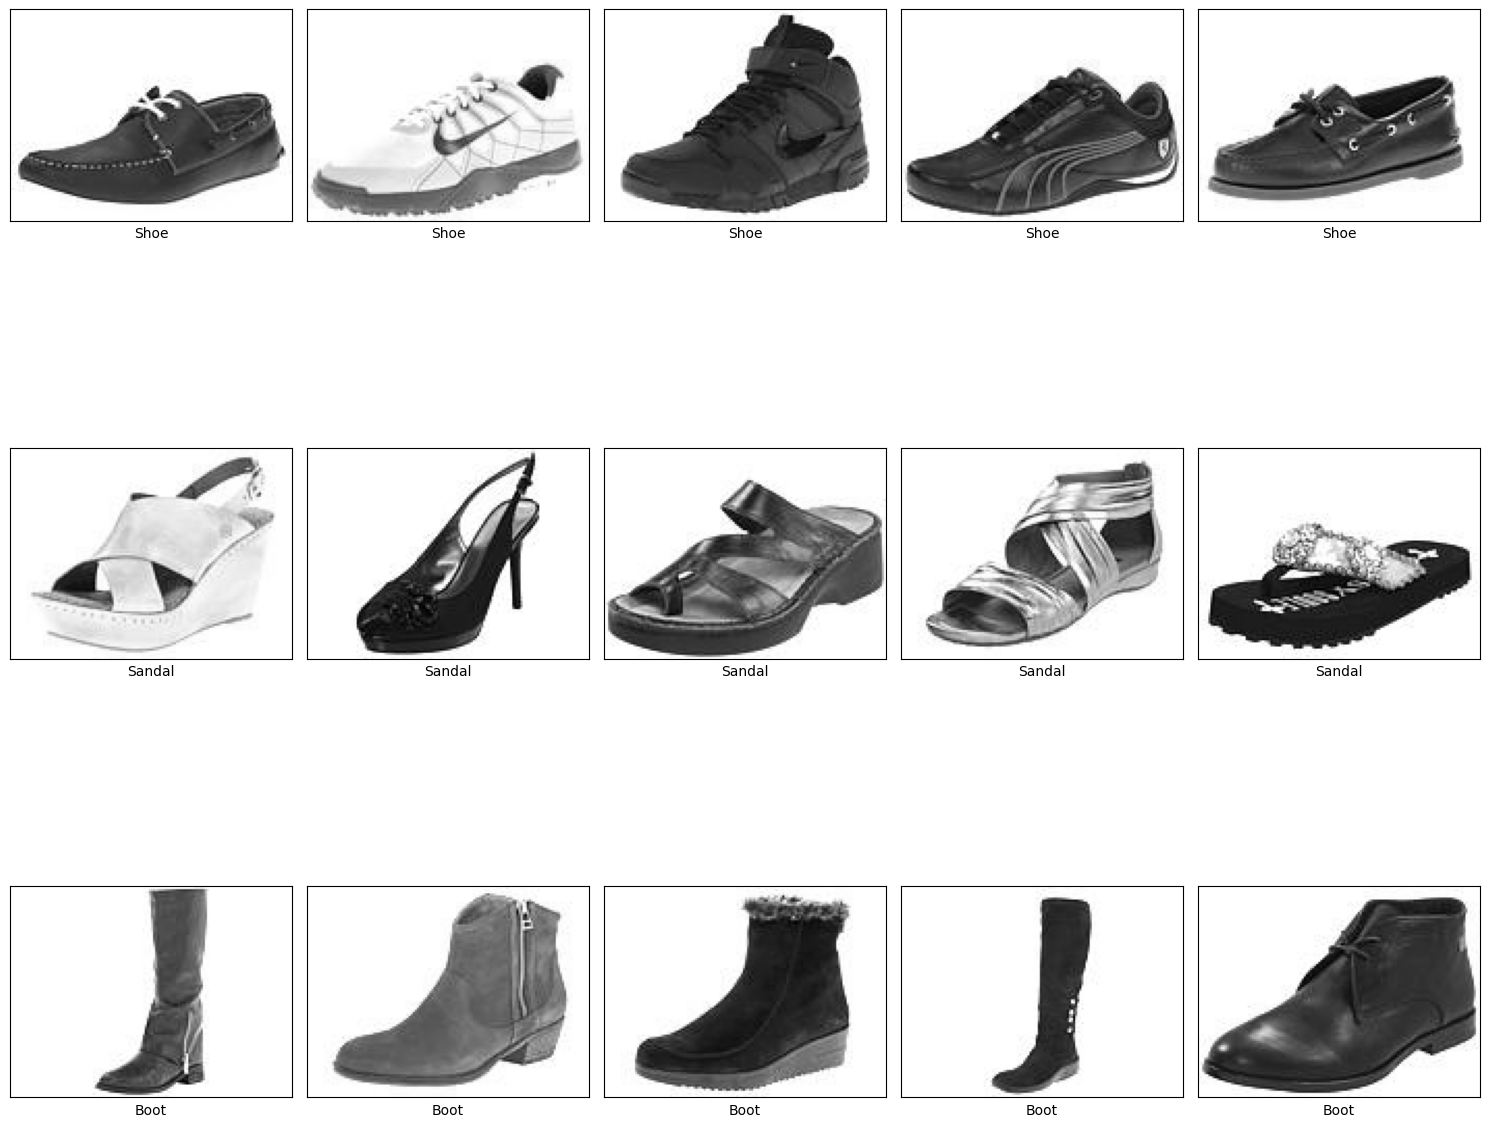

In [ ]:
# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
lung_image = {}

# Tentukan path sumber train
path = "Shoe_vs_Sandal_vs_Boot_Dataset/"
path_sub = os.path.join(path, "dataset")
for i in os.listdir(path_sub):
    lung_image[i] = os.listdir(os.path.join(path_sub, i))

# Menampilkan secara acak 5 gambar di bawah setiap dari 2 kelas dari data.
# Anda akan melihat gambar yang berbeda setiap kali.
path_sub = "Shoe_vs_Sandal_vs_Boot_Dataset/dataset"

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(lung_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(lung_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path)  # Konversi menjadi skala keabuan
        axs[i, j].imshow(img)
        img = Image.open(img_path).convert("L")
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])

fig.tight_layout()

#### Plot distribusi gambar di seluruh kelas

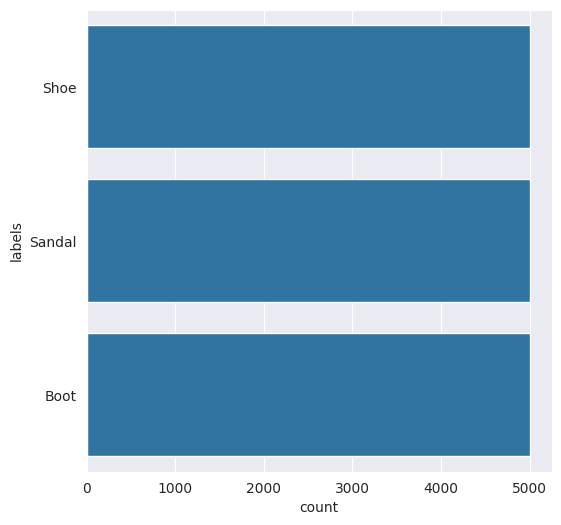

In [ ]:
# Tentukan jalur sumber
lung_path = "Shoe_vs_Sandal_vs_Boot_Dataset/dataset"

# Buat daftar yang menyimpan data untuk setiap nama file, jalur file, dan
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar data, jalur file, label satu per satu dengan perulangan, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

# Plot distribusi gambar di seluruh kelas
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

### Data Augmentation

Proses augmentasi gambar adalah teknik yang digunakan untuk membuat variasi baru dari setiap gambar dalam dataset, sehingga model memiliki lebih banyak variasi untuk dipelajari. Ini membantu mencegah overfitting, di mana model terlalu terbiasa dengan data pelatihan dan tidak dapat menggeneralisasi dengan baik ke data baru.

Berikut adalah beberapa strategi augmentasi gambar yang dapat kita terapkan:

- `anticlockwise_rotation` adalah ketika gambar diputar ke arah berlawanan dengan arah jarum jam.
- `clockwise_rotation` adalah ketika gambar diputar ke arah searah dengan arah jarum jam.
- `flip_up_down` adalah ketika gambar dibalik secara vertikal dari atas ke bawah.
- `sheared` adalah ketika gambar diberikan efek pergeseran acak.
- `blur` adalah ketika gambar diberikan efek kabur atau blur.
- `wrap_shift` adalah ketika gambar diberikan efek pergeseran melengkung.
- `brightness` adalah ketika gambar diberikan efek peningkatan kecerahan.

In [ ]:
# Membuat fungsi untuk melakukan rotasi berlawanan arah jarum jam
def anticlockwise_rotation(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.rot90(img, k=random.randint(1, 4))  # Rotasi 90, 180, atau 270 derajat secara acak
    return img

# Membuat fungsi untuk melakukan rotasi searah jarum jam
def clockwise_rotation(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.rot90(img, k=random.randint(1, 4))  # Rotasi 90, 180, atau 270 derajat secara acak
    return img

# Membuat fungsi untuk membalik gambar secara vertikal dari atas ke bawah
def flip_up_down(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.flip_up_down(img)
    return img

# Membuat fungsi untuk memberikan efek peningkatan kecerahan pada gambar
def add_brightness(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.adjust_brightness(img, delta=random.uniform(0.1, 0.5))  # Sesuaikan nilai delta sesuai kebutuhan
    return img

# Membuat fungsi untuk memberikan efek blur pada gambar
def blur_image(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return cv2.GaussianBlur(img, (9,9),0)

# Membuat fungsi untuk memberikan efek pergeseran acak pada gambar
def sheared(img):
    img = tf.image.resize(img, (224, 224))
    # Buat objek ImageDataGenerator dengan parameter shearing range
    datagen = ImageDataGenerator(shear_range=0.2)
    img = next(iter(datagen.flow(tf.expand_dims(img, 0))))[0]
    return img

# Membuat fungsi untuk melakukan pergeseran melengkung pada gambar
def warp_shift(img):
    img = tf.image.resize(img, (224, 224))
    # Buat objek ImageDataGenerator dengan parameter width_shift_range dan height_shift_range
    datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1)
    img = next(iter(datagen.flow(tf.expand_dims(img, 0))))[0]
    return img

In [ ]:
transformations = {
    'rotate anticlockwise': anticlockwise_rotation,
    'rotate clockwise': clockwise_rotation,
    'warp shift': warp_shift,
    'blurring image': blur_image,
    'add brightness': add_brightness,
    'flip up down': flip_up_down,
    'shear image': sheared
}

images_path = "Shoe_vs_Sandal_vs_Boot_Dataset/dataset/Boot"     # Path untuk gambar asli
augmented_path = "Shoe_vs_Sandal_vs_Boot_Dataset/dataset/Boot"  # Path untuk meletakkan gambar yang ditambah
images = []  # Untuk menyimpan gambar yang sudah dipra-proses dari folder

# Baca nama gambar dari folder dan tambahkan path ke dalam array "images"
for im in os.listdir(images_path):
    images.append(os.path.join(images_path, im))

# Jumlah gambar yang akan ditambahkan dengan hasil transformasi augmentasi
images_to_generate = 1000
i = 1

while i <= images_to_generate:
    image = random.choice(images)
    try:
        original_image = io.imread(image)

        # Memeriksa apakah gambar memiliki dimensi yang valid (3 atau 4 dimensi)
        if original_image.ndim not in [3, 4]:
            raise ValueError('Invalid image dimensions')

        transformed_image = None
        n = 0  # Variabel untuk melakukan iterasi sampai jumlah transformasi yang akan diterapkan
        transformation_count = random.randint(1, len(transformations))  # Pilih jumlah transformasi acak yang akan diterapkan pada gambar

        while n <= transformation_count:
            key = random.choice(list(transformations))  # Secara acak memilih dan memanggil metode
            transformed_image = transformations[key](original_image)
            n = n + 1

        new_image_path = "%s/augmented_image_%s.jpg" % (augmented_path, i)
        transformed_image = img_as_ubyte(transformed_image)  # Mengonversi gambar ke format byte yang tidak ditandatangani, dengan nilai dalam [0, 255]
        cv2.imwrite(new_image_path, transformed_image)  # Simpan hasil transformasi augmentasi pada gambar ke path yang ditentukan
        i = i + 1
    except ValueError as e:
        print('Could not read or process the image', image, ':', e, 'hence skipping it.')

Streaming output truncated to the last 5000 lines.
Could not read or process the image Shoe_vs_Sandal_vs_Boot_Dataset/dataset/Boot/boot (258).jpg : Images of type float must be between -1 and 1. hence skipping it.
Could not read or process the image Shoe_vs_Sandal_vs_Boot_Dataset/dataset/Boot/boot (259).jpg : Images of type float must be between -1 and 1. hence skipping it.
Could not read or process the image Shoe_vs_Sandal_vs_Boot_Dataset/dataset/Boot/boot (1674).jpg : Images of type float must be between -1 and 1. hence skipping it.
Could not read or process the image Shoe_vs_Sandal_vs_Boot_Dataset/dataset/Boot/boot (3086).jpg : Images of type float must be between -1 and 1. hence skipping it.
Could not read or process the image Shoe_vs_Sandal_vs_Boot_Dataset/dataset/Boot/boot (3605).jpg : Images of type float must be between -1 and 1. hence skipping it.
Could not read or process the image Shoe_vs_Sandal_vs_Boot_Dataset/dataset/Boot/boot (4740).jpg : Images of type float must be betw

In [ ]:
transformations = {
    'rotate anticlockwise': anticlockwise_rotation,
    'rotate clockwise': clockwise_rotation,
    'warp shift': warp_shift,
    'blurring image': blur_image,
    'add brightness': add_brightness,
    'flip up down': flip_up_down,
    'shear image': sheared
}

images_path = "Shoe_vs_Sandal_vs_Boot_Dataset/dataset/Shoe"     # Path untuk gambar asli
augmented_path = "Shoe_vs_Sandal_vs_Boot_Dataset/dataset/Shoe"  # Path untuk meletakkan gambar yang ditambah
images = []  # Untuk menyimpan gambar yang sudah dipra-proses dari folder

# Baca nama gambar dari folder dan tambahkan path ke dalam array "images"
for im in os.listdir(images_path):
    images.append(os.path.join(images_path, im))

# Jumlah gambar yang akan ditambahkan dengan hasil transformasi augmentasi
images_to_generate = 1000
i = 1

while i <= images_to_generate:
    image = random.choice(images)
    try:
        original_image = io.imread(image)

        # Memeriksa apakah gambar memiliki dimensi yang valid (3 atau 4 dimensi)
        if original_image.ndim not in [3, 4]:
            raise ValueError('Invalid image dimensions')

        transformed_image = None
        n = 0  # Variabel untuk melakukan iterasi sampai jumlah transformasi yang akan diterapkan
        transformation_count = random.randint(1, len(transformations))  # Pilih jumlah transformasi acak yang akan diterapkan pada gambar

        while n <= transformation_count:
            key = random.choice(list(transformations))  # Secara acak memilih dan memanggil metode
            transformed_image = transformations[key](original_image)
            n = n + 1

        new_image_path = "%s/augmented_image_%s.jpg" % (augmented_path, i)
        transformed_image = img_as_ubyte(transformed_image)  # Mengonversi gambar ke format byte yang tidak ditandatangani, dengan nilai dalam [0, 255]
        cv2.imwrite(new_image_path, transformed_image)  # Simpan hasil transformasi augmentasi pada gambar ke path yang ditentukan
        i = i + 1
    except ValueError as e:
        print('Could not read or process the image', image, ':', e, 'hence skipping it.')

Streaming output truncated to the last 5000 lines.
Could not read or process the image Shoe_vs_Sandal_vs_Boot_Dataset/dataset/Shoe/Shoe (1321).jpg : Images of type float must be between -1 and 1. hence skipping it.
Could not read or process the image Shoe_vs_Sandal_vs_Boot_Dataset/dataset/Shoe/Shoe (2370).jpg : Images of type float must be between -1 and 1. hence skipping it.
Could not read or process the image Shoe_vs_Sandal_vs_Boot_Dataset/dataset/Shoe/Shoe (606).jpg : Images of type float must be between -1 and 1. hence skipping it.
Could not read or process the image Shoe_vs_Sandal_vs_Boot_Dataset/dataset/Shoe/Shoe (2684).jpg : Images of type float must be between -1 and 1. hence skipping it.
Could not read or process the image Shoe_vs_Sandal_vs_Boot_Dataset/dataset/Shoe/Shoe (4447).jpg : Images of type float must be between -1 and 1. hence skipping it.
Could not read or process the image Shoe_vs_Sandal_vs_Boot_Dataset/dataset/Shoe/Shoe (2886).jpg : Images of type float must be bet

In [ ]:
transformations = {
    'rotate anticlockwise': anticlockwise_rotation,
    'rotate clockwise': clockwise_rotation,
    'warp shift': warp_shift,
    'blurring image': blur_image,
    'add brightness': add_brightness,
    'flip up down': flip_up_down,
    'shear image': sheared
}

images_path = "Shoe_vs_Sandal_vs_Boot_Dataset/dataset/Sandal"     # Path untuk gambar asli
augmented_path = "Shoe_vs_Sandal_vs_Boot_Dataset/dataset/Sandal"  # Path untuk meletakkan gambar yang ditambah
images = []  # Untuk menyimpan gambar yang sudah dipra-proses dari folder

# Baca nama gambar dari folder dan tambahkan path ke dalam array "images"
for im in os.listdir(images_path):
    images.append(os.path.join(images_path, im))

# Jumlah gambar yang akan ditambahkan dengan hasil transformasi augmentasi
images_to_generate = 1000
i = 1

while i <= images_to_generate:
    image = random.choice(images)
    try:
        original_image = io.imread(image)

        # Memeriksa apakah gambar memiliki dimensi yang valid (3 atau 4 dimensi)
        if original_image.ndim not in [3, 4]:
            raise ValueError('Invalid image dimensions')

        transformed_image = None
        n = 0  # Variabel untuk melakukan iterasi sampai jumlah transformasi yang akan diterapkan
        transformation_count = random.randint(1, len(transformations))  # Pilih jumlah transformasi acak yang akan diterapkan pada gambar

        while n <= transformation_count:
            key = random.choice(list(transformations))  # Secara acak memilih dan memanggil metode
            transformed_image = transformations[key](original_image)
            n = n + 1

        new_image_path = "%s/augmented_image_%s.jpg" % (augmented_path, i)
        transformed_image = img_as_ubyte(transformed_image)  # Mengonversi gambar ke format byte yang tidak ditandatangani, dengan nilai dalam [0, 255]
        cv2.imwrite(new_image_path, transformed_image)  # Simpan hasil transformasi augmentasi pada gambar ke path yang ditentukan
        i = i + 1
    except ValueError as e:
        print('Could not read or process the image', image, ':', e, 'hence skipping it.')

Streaming output truncated to the last 5000 lines.
Could not read or process the image Shoe_vs_Sandal_vs_Boot_Dataset/dataset/Sandal/Sandal (3199).jpg : Images of type float must be between -1 and 1. hence skipping it.
Could not read or process the image Shoe_vs_Sandal_vs_Boot_Dataset/dataset/Sandal/Sandal (3615).jpg : Images of type float must be between -1 and 1. hence skipping it.
Could not read or process the image Shoe_vs_Sandal_vs_Boot_Dataset/dataset/Sandal/Sandal (2994).jpg : Images of type float must be between -1 and 1. hence skipping it.
Could not read or process the image Shoe_vs_Sandal_vs_Boot_Dataset/dataset/Sandal/Sandal (4615).jpg : Images of type float must be between -1 and 1. hence skipping it.
Could not read or process the image Shoe_vs_Sandal_vs_Boot_Dataset/dataset/Sandal/Sandal (3634).jpg : Images of type float must be between -1 and 1. hence skipping it.
Could not read or process the image Shoe_vs_Sandal_vs_Boot_Dataset/dataset/Sandal/Sandal (1227).jpg : Images 

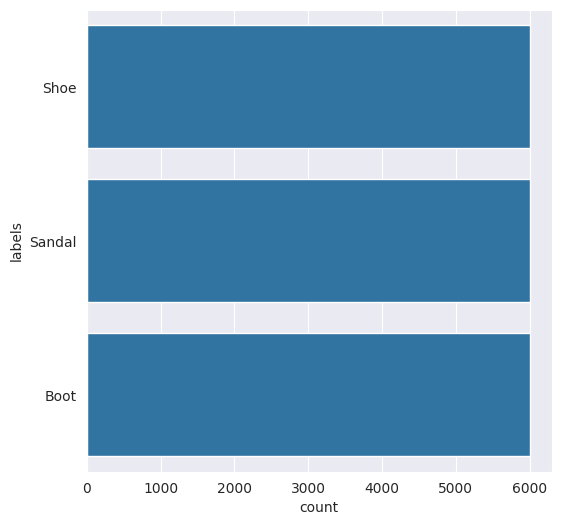

In [ ]:
# Tentukan path sumber
lung_path = "Shoe_vs_Sandal_vs_Boot_Dataset/dataset"

# Buat list yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Ambil satu per satu nama file gambar, path file, dan label dengan perulangan, lalu simpan sebagai dataframe
for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

# Buat dataframe berisi path, nama file, dan label
distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

# Plot distribusi jumlah gambar pada masing-masing kelas
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

# **Data Preprocessing**

## **Split Dataset**

In [ ]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath= 'Shoe_vs_Sandal_vs_Boot_Dataset/dataset'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)


# Memasukan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapih
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

labels
Boot      6000
Sandal    6000
Shoe      6000
dtype: int64

In [ ]:
# Variabel yang digunakan pada pemisahan data ini dimana variabel x = data path dan y = data labels
X = df['path']
y = df['labels']

# Split data menjadi 80% train dan 20% sisa (val + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=300, stratify=y
)

# Split sisa 40% menjadi masing-masing 10% (val) dan 10% (test)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=300, stratify=y_temp
)

In [ ]:
# Menyatukan kedalam masing-masing dataframe
df_tr = pd.DataFrame({'path': X_train, 'labels': y_train, 'set': 'train'})
df_te = pd.DataFrame({'path': X_test, 'labels': y_test, 'set': 'test'})
df_val = pd.DataFrame({'path': X_val, 'labels': y_val, 'set': 'val'})

# Print hasil diatas untuk melihat panjang size data training, testing dan validation
print('train size', len(df_tr))
print('test size', len(df_te))
print('val size', len(df_val))

train size 14400
test size 1800
val size 1800


In [ ]:
# Gabungkan DataFrame df_tr, df_te dan df_val
df_all = pd.concat([df_tr, df_te, df_val], ignore_index=True)

print(df_all.groupby(['set', 'labels']).size(), '\n')
print('=====================================================\n')
print(df_all.sample(5))

set    labels
test   Boot       600
       Sandal     600
       Shoe       600
train  Boot      4800
       Sandal    4800
       Shoe      4800
val    Boot       600
       Sandal     600
       Shoe       600
dtype: int64 


                                                    path  labels    set
9325   Shoe_vs_Sandal_vs_Boot_Dataset/dataset/Shoe/Sh...    Shoe  train
8340   Shoe_vs_Sandal_vs_Boot_Dataset/dataset/Sandal/...  Sandal  train
17013  Shoe_vs_Sandal_vs_Boot_Dataset/dataset/Shoe/Sh...    Shoe    val
2057   Shoe_vs_Sandal_vs_Boot_Dataset/dataset/Sandal/...  Sandal  train
12097  Shoe_vs_Sandal_vs_Boot_Dataset/dataset/Sandal/...  Sandal  train


In [ ]:
# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "Shoe_vs_Sandal_vs_Boot_Dataset/"
# Membuat variabel Dataset, dimana nanti menampung data yang telah dilakukan pembagian data training, testing dan validation
dataset_path = "Dataset_Final/"

In [ ]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

### Generator Data Gambar

Dalam TensorFlow Anda dapat melakukan ini melalui kelas `tf.keras.preprocessing.image.ImageDataGenerator`. Kelas ini memungkinkan Anda untuk melakukan:
- Mengonfigurasi transformasi acak dan operasi normalisasi yang akan dilakukan pada data gambar selama pelatihan
- Menginstansiasi generator set gambar yang telah ditambah (dan labelnya) melalui `.flow(data, label)` atau `.flow_from_directory(direktori)`. Generator ini kemudian dapat digunakan dengan metode model `tf.keras` yang menerima data generator sebagai input, `cocokkan`, `evaluasi`, dan `prediksi`

Siapkan data pelatihan dan validasi, untuk memulai dengan menggunakan `.flow_from_directory()` yang menghasilkan dataset gambar dan labelnya secara langsung di folder masing-masing dengan mengatur ukuran `WIDTH` dan `HEIGHT`, ukuran `BATCH SIZE` yang telah ditentukan dan mode kelasnya. Di sini kita menggunakan mode kelas `“categorical” karena jumlah kelas yang digunakan adalah 3.

In [ ]:
# Tentukan direktori untuk data pelatihan dan pengujian
TRAIN_DIR = 'Dataset_Final/train'
TEST_DIR = 'Dataset_Final/test'
VAL_DIR = 'Dataset_Final/val'

# Daftar semua kelas
classes = ['Boot', 'Sandal', 'Shoe']

# Cek jumlah gambar untuk setiap kelas di data pelatihan
print("TRAINING SET")
for class_name in classes:
    class_path = os.path.join(TRAIN_DIR, class_name)
    print(f"Total {class_name} images: {len(os.listdir(class_path))}")

# Cek jumlah gambar untuk setiap kelas di data pengujian
print("\nTEST SET")
for class_name in classes:
    class_path = os.path.join(TEST_DIR, class_name)
    print(f"Total {class_name} images: {len(os.listdir(class_path))}")

# Cek jumlah gambar untuk setiap kelas di data validasi
print("\nVAL SET")
for class_name in classes:
    class_path = os.path.join(VAL_DIR, class_name)
    print(f"Total {class_name} images: {len(os.listdir(class_path))}")

TRAINING SET
Total Boot images: 4800
Total Sandal images: 4800
Total Shoe images: 4800

TEST SET
Total Boot images: 600
Total Sandal images: 600
Total Shoe images: 600

VAL SET
Total Boot images: 600
Total Sandal images: 600
Total Shoe images: 600


In [ ]:
# Membuat objek ImageDataGenerator yang menormalkan gambar
train_datagen = ImageDataGenerator(rescale=1./255.,
                                   validation_split = 0.2)
val_datagen = ImageDataGenerator(rescale=1./255.,
                                 validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=(128,128),
        batch_size = 32,
        color_mode="grayscale",
        class_mode='categorical',
        seed=123,
        shuffle=True
        )

validation_generator = val_datagen.flow_from_directory(
        VAL_DIR,
        target_size=(128,128),
        batch_size = 32,
        color_mode="grayscale",
        class_mode='categorical',
        seed=123,
        shuffle=False
        )

test_generator = test_datagen.flow_from_directory(
        TEST_DIR,
        target_size=(128,128),
        batch_size = 32,
        color_mode="grayscale",
        class_mode='categorical',
        seed=123,
        shuffle=False
        )

Found 14400 images belonging to 3 classes.
Found 1800 images belonging to 3 classes.
Found 1800 images belonging to 3 classes.


In [ ]:
# Dapatkan indeks kelas yang ditetapkan oleh generator
class_indices_train = train_generator.class_indices

# Mencetak indeks kelas
print(class_indices_train)

{'Boot': 0, 'Sandal': 1, 'Shoe': 2}


## **Modelling**

In [ ]:
# Model Sequential
model = Sequential()

# Layer Konvolusi Pertama
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu',
                 kernel_initializer=he_normal(), input_shape=(128, 128, 1), name='CONV_Layer1'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))  # Layer pooling untuk mengurangi dimensi
model.add(BatchNormalization())  # Normalisasi batch untuk mempercepat dan menstabilkan pelatihan

# Layer Konvolusi Kedua
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu',
                 kernel_initializer=he_normal(), name='CONV_Layer2'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))  # Pooling lagi
model.add(BatchNormalization())  # Normalisasi batch
model.add(Dropout(0.40))  # Dropout untuk mengurangi overfitting

# Layer Konvolusi Ketiga
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu',
                 kernel_initializer=he_normal(), name='CONV_Layer3'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))  # Pooling
model.add(BatchNormalization())  # Normalisasi batch
model.add(Dropout(0.40))  # Dropout kembali

# Flatten Layer untuk mengubah data 2D menjadi 1D sebelum masuk ke dense layer
model.add(Flatten(name='Flatten'))

# Fully Connected Layer (Dense)
model.add(Dense(220, activation='relu', kernel_initializer=he_normal(), name='FullyConnected1'))  # Layer dense pertama
model.add(Dense(64, activation="relu"))  # Layer dense kedua

# Output Layer dengan 3 neuron untuk 3 kelas dan aktivasi softmax
model.add(Dense(3, activation='softmax', kernel_initializer=he_normal(), name='OutputLayer'))

# Kompilasi model menggunakan loss categorical_crossentropy dan optimizer Adam
model.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])

# Menampilkan ringkasan arsitektur model
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ CONV_Layer1 (Conv2D)            │ (None, 128, 128, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ CONV_Layer2 (Conv2D)            │ (None, 64, 64, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ CONV_Layer3 (Conv2D)            │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FullyConnected1 (Dense)         │ (None, 220)            │     1,802,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        14,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ OutputLayer (Dense)             │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,845,663 (7.04 MB)

 Trainable params: 1,845,407 (7.04 MB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
#Early_Stopping
early_stopping = EarlyStopping(
    min_delta=0.001,
    patience=5,
    restore_best_weights=True,
)

%time

# Fitting / training model
history = model.fit(train_generator,
                        epochs= 30,
                        steps_per_epoch = len(train_generator),
                        validation_data = validation_generator,
                        validation_steps = len(validation_generator),
                        callbacks = early_stopping)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 16 µs
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


450/450 ━━━━━━━━━━━━━━━━━━━━ 660s 1s/step - accuracy: 0.8481 - loss: 0.4384 - val_accuracy: 0.8883 - val_loss: 0.3445
Epoch 2/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 659s 1s/step - accuracy: 0.9556 - loss: 0.1174 - val_accuracy: 0.9533 - val_loss: 0.1206
Epoch 3/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 702s 2s/step - accuracy: 0.9711 - loss: 0.0777 - val_accuracy: 0.9567 - val_loss: 0.1567
Epoch 4/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 666s 1s/step - accuracy: 0.9797 - loss: 0.0549 - val_accuracy: 0.9661 - val_loss: 0.1197
Epoch 5/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 668s 1s/step - accuracy: 0.9861 - loss: 0.0445 - val_accuracy: 0.9728 - val_loss: 0.1049
Epoch 6/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 675s 1s/step - accuracy: 0.9879 - loss: 0.0328 - val_accuracy: 0.9706 - val_loss: 0.1079
Epoch 7/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 661s 1s/step - accuracy: 0.9876 - loss: 0.0331 - val_accuracy: 0.9778 - val_loss: 0.0943
Epoch 8/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 675s 1s/step - accuracy: 0.9918 - loss: 0.0230 - val_accuracy: 0.963

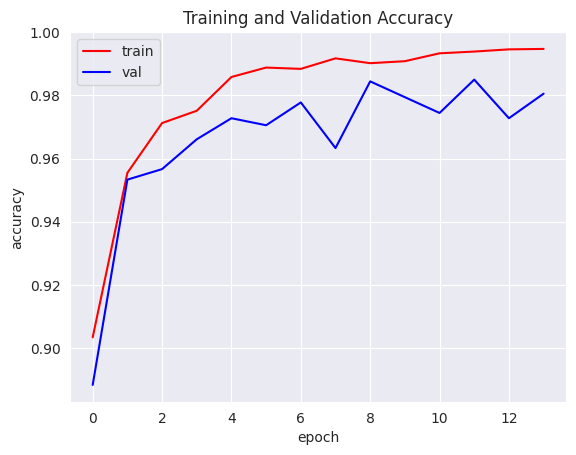

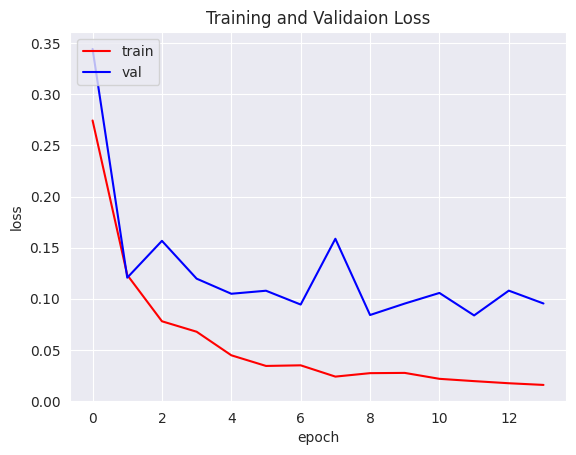

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

## **Evaluasi dan Visualisasi**

In [ ]:
# Mengevaluasi model pada dataset validasi
validation_loss, validation_accuracy = model.evaluate(validation_generator)

# Menampilkan loss dan akurasi validasi
print("Validation Loss:", validation_loss)
print("Validation Accuracy:", validation_accuracy)

# Mengevaluasi model pada dataset pengujian
test_loss, test_accuracy = model.evaluate(test_generator)

# Menampilkan loss dan akurasi pengujian
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

57/57 ━━━━━━━━━━━━━━━━━━━━ 25s 419ms/step - accuracy: 0.9845 - loss: 0.0924
Validation Loss: 0.08409535139799118
Validation Accuracy: 0.9844444394111633
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 343ms/step - accuracy: 0.9856 - loss: 0.0566
Test Loss: 0.06103430315852165
Test Accuracy: 0.9838888645172119




              precision    recall  f1-score   support

        Boot     0.9916    0.9867    0.9891       600
      Sandal     0.9899    0.9800    0.9849       600
        Shoe     0.9704    0.9850    0.9777       600

    accuracy                         0.9839      1800
   macro avg     0.9840    0.9839    0.9839      1800
weighted avg     0.9840    0.9839    0.9839      1800



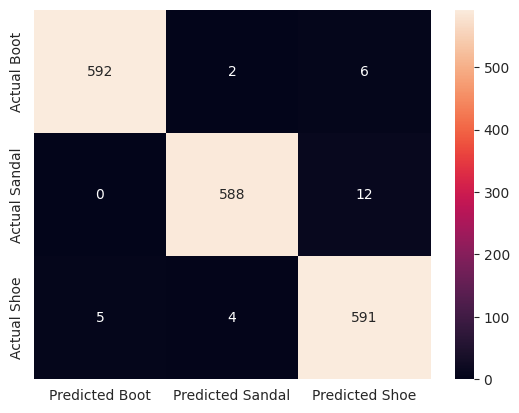

In [ ]:
test_generator.reset()

preds_1 = model.predict(test_generator,verbose=0)
# Mengonversi prediksi menjadi label kelas (format multikelas)
predicted_classes = np.argmax(preds_1, axis=1)

# Dapatkan label kelas yang benar (format multikelas)
true_classes = test_generator.classes

# Cetak Matriks Kebingungan dengan semua kelas
num_classes = len(train_generator.class_indices)   # Dapatkan jumlah kelas
cm = pd.DataFrame(
    data=confusion_matrix(true_classes, predicted_classes, labels=range(num_classes)),
    index=[f"Actual {class_name}" for class_name in train_generator.class_indices],
    columns=[f"Predicted {class_name}" for class_name in train_generator.class_indices]
)
sns.heatmap(cm, annot=True, fmt="d")

# Mencetak Laporan Klasifikasi dengan semua kelas
print("\n")
print(classification_report(
    y_true=true_classes,
    y_pred=predicted_classes,
    target_names=train_generator.class_indices, # Gunakan semua nama kelas
    digits=4
))

## **Konversi Model**

In [ ]:
save_path = 'saved_model/'
tf.saved_model.save(model, save_path)

In [ ]:
# Konversi SavedModel ke TFLite
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model/')
tflite_model = converter.convert()

# Buat direktori tflite
os.makedirs('tflite', exist_ok=True)

# Simpan model TFLite
with open('tflite/model.tflite', 'wb') as f:
    f.write(tflite_model)

# Simpan label ke label.txt
labels = ["Shoe", "Sandal", "Boot"]
with open('tflite/label.txt', 'w') as f:
    for label in labels:
        f.write(label + '\n')

In [ ]:
# Install tensorflowjs
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.7 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [ ]:
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    --output_format=tfjs_graph_model \
    --signature_name=serving_default \
    --saved_model_tags=serve \
    saved_model/ \
    tfjs_model/

2025-05-15 15:54:05.132230: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747324445.158923   72907 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747324445.166362   72907 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-05-15 15:54:12.106657: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
I0000 00:00:1747324452.492202   72907 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00

## **Inference (Optional)**

Found 1800 images belonging to 3 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


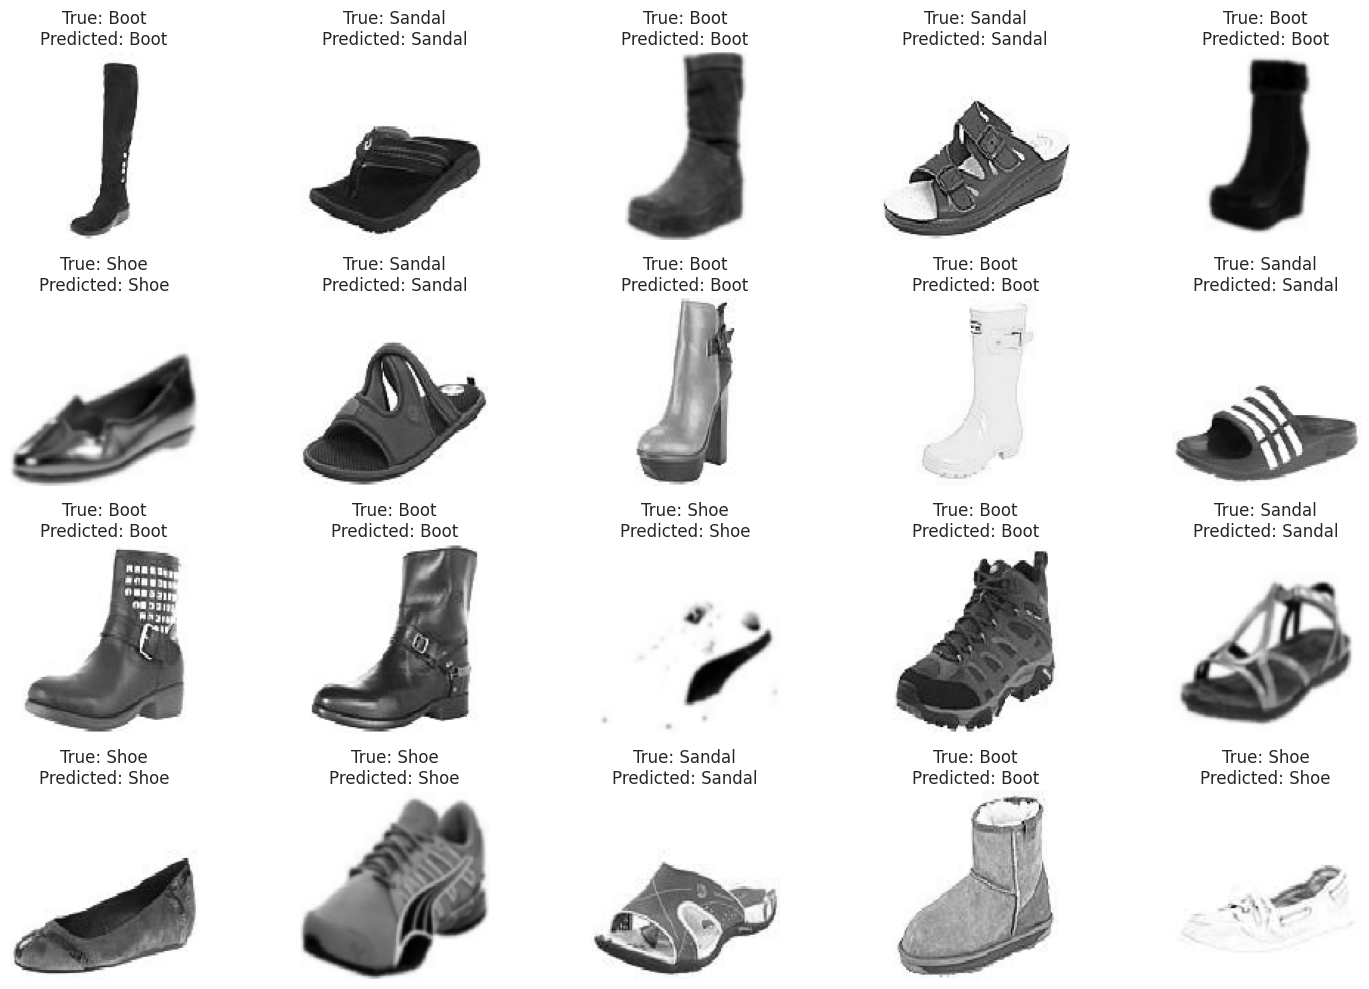

In [ ]:
# Path untuk test dataset
TEST_DIR = "Dataset_Final/test"

# Define image data generator for test dataset (with normalization)
test_datagen = ImageDataGenerator(rescale=1./255)

# Tentukan generator data gambar untuk test dataset (dengan normalisasi)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(128, 128),
    batch_size=1,
    class_mode='categorical',
    shuffle=True,
    color_mode="grayscale"
)

# Dapatkan label kelas
class_labels = list(test_generator.class_indices.keys())

# Memprediksi setiap gambar dan hasil plot
num_images = 20
plt.figure(figsize=(15, 10))
for i in range(num_images):
    image, label = next(test_generator)
    prediction = model.predict(image)
    predicted_class = class_labels[np.argmax(prediction)]
    true_class = class_labels[np.argmax(label)]

    plt.subplot(4, 5, i + 1)
    plt.imshow(image[0], cmap='gray')
    plt.title(f'True: {true_class}\nPredicted: {predicted_class}')
    plt.axis('off')

plt.tight_layout()
plt.show()

Saving Cuplikan layar 2025-05-13 185827.png to Cuplikan layar 2025-05-13 185827.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


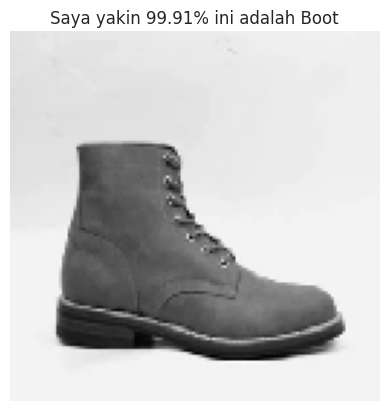

In [ ]:
from tensorflow.keras.preprocessing import image
from google.colab import files

# Upload file gambar
uploaded = files.upload()

classes = ['Boot', 'Sandal', 'Shoe']

for fn in uploaded.keys():
    # Load gambar dari file menggunakan modul image dari Keras
    test_img = image.load_img(fn, target_size=(128, 128), color_mode='grayscale')

    # Konversi ke array dan preprocessing
    pp_test_img = image.img_to_array(test_img)
    pp_test_img = pp_test_img / 255.0
    pp_test_img = np.expand_dims(pp_test_img, axis=0)

    # Prediksi model
    predictions = model.predict(pp_test_img)
    predicted_class_index = np.argmax(predictions[0])
    predicted_class_name = classes[predicted_class_index]
    confidence = predictions[0][predicted_class_index] * 100

    # Tampilkan hasil prediksi
    plt.imshow(np.squeeze(pp_test_img), cmap='gray')
    plt.title(f"Saya yakin {confidence:.2f}% ini adalah {predicted_class_name}")
    plt.axis('off')
    plt.show()

In [ ]:
 pip freeze requirements.txt

absl-py==1.4.0
accelerate==1.6.0
aiohappyeyeballs==2.6.1
aiohttp==3.11.15
aiosignal==1.3.2
alabaster==1.0.0
albucore==0.0.24
albumentations==2.0.6
ale-py==0.11.0
altair==5.5.0
annotated-types==0.7.0
antlr4-python3-runtime==4.9.3
anyio==4.9.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.7.2
arviz==0.21.0
astropy==7.0.1
astropy-iers-data==0.2025.5.5.0.38.14
astunparse==1.6.3
atpublic==5.1
attrs==25.3.0
audioread==3.0.1
autograd==1.8.0
babel==2.17.0
backcall==0.2.0
backports.tarfile==1.2.0
beautifulsoup4==4.13.4
betterproto==2.0.0b6
bigframes==2.3.0
bigquery-magics==0.9.0
bleach==6.2.0
blinker==1.9.0
blis==1.3.0
blobfile==3.0.0
blosc2==3.3.2
bokeh==3.7.2
Bottleneck==1.4.2
bqplot==0.12.44
branca==0.8.1
build==1.2.2.post1
CacheControl==0.14.3
cachetools==5.5.2
catalogue==2.0.10
certifi==2025.4.26
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.2
chex==0.1.89
clarabel==0.10.0
click==8.1.8
cloudpathlib==0.21.0
cloudpickle==3.1.1
cmake==3.31.6
cmdstanpy==1.2.5
colorcet=